# Assignment 2

In this assignment, you will be working on an image classification task (codename `pnp`) using the transfer learning technique.
The task objective is to determine whether an image contains a person (`pnp` stands for person / non-person) -- a binary classification task.

## Dataset
* Dataset contains 80K images with known labels (for model development), and 20K images with unknown labels (for scoring).
* Dataset has been created from a subset of COCO Dataset, and so all copyrights belong to the original authors: https://cocodataset.org/#termsofuse
* Images have been rescaled and padded to be of shape (224, 224, 3).

While it's possible to create a new model architecture and train a model specifically for this task, that would be expensive in terms of time and cloud resources.
Instead, in this assignment, you will be re-using an pre-trained model's architecture and parameters to save time and cloud resources.

## MobileNet Architecture
* The pre-trained model's name is MobileNetV2: https://arxiv.org/pdf/1801.04381.pdf
* MobileNet is a relatively small network that is designed for usage on mobile devices with limited compute and storage resource.
* It's a great choice for this assignment, since this network can be relatively quickly processed with a single GPU.

## MobileNet Parameters
* Keras provides network architecture and pre-trained parameters: https://keras.io/api/applications/mobilenet/#mobilenetv2-function
* The pre-trained parameters come from the ImageNet 1000-class task, which does not include a person label.
* The lower part of the network can be reused due to the shared hierarchy of visual information..


In [1]:
!ls pnp_dataset.zip || (wget https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip)

pnp_dataset.zip


In [1]:
import matplotlib.pyplot as plt

In [1]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1728165419.188963   19890 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728165419.241046   19890 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728165419.242183   19890 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [1]:
from collegium.m02_cnn.utils.pnp_dataset import build_dataset

# See Tensorflow Dataset API for details
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
train_ds = build_dataset('train', include_labels=True)
score_ds = build_dataset('score', include_labels=False)
train_ds, score_ds

I0000 00:00:1728165409.771198   19653 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728165409.823479   19653 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728165409.824650   19653 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728165409.827924   19653 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

(<_FlatMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <_FlatMapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


<tf.Tensor: shape=(), dtype=int32, numpy=1>

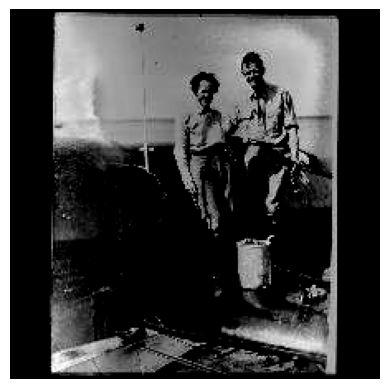

In [4]:
train_sample_x, train_sample_y = next(iter(train_ds))
plt.imshow(train_sample_x)
plt.axis('off')
train_sample_y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


<tf.Tensor: shape=(), dtype=int32, numpy=0>

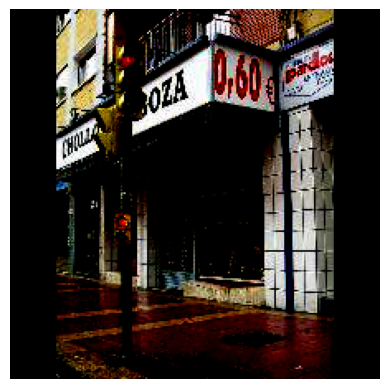

In [5]:
train_sample_x, train_sample_y = next(iter(train_ds.skip(1)))
plt.imshow(train_sample_x)
plt.axis('off')
train_sample_y

In [7]:
# https://arxiv.org/pdf/1801.04381.pdf
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)

In [8]:
# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
mobile_net.trainable = False

In [9]:
# mobile_net.summary()

In [10]:
model = tf.keras.models.Sequential([
    mobile_net,
    tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1)
])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 1280)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ],
)
batch_size = 128

In [28]:
model.fit(
    train_ds.batch(batch_size),
    epochs=1,
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - binary_accuracy: 0.5130 - loss: 7.8492


In [18]:
import os 
import pandas as pd

model_dir = 'pnp_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the model on the score dataset.
score_y_hat = pd.DataFrame(
    model.predict(score_ds.batch(batch_size)),
    # This is needed to save the file in Parquet format.
    columns=['score']
)

# Now save it to disc as a Parquet file.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')
assert score_y_hat.shape == (20000, 1)

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/model_architecture.json', 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), indent=True))

# Finally, let's save the learned parameters.
tf.keras.models.save_model(model, f'{model_dir}/model.keras')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. model_architecture.json -- the model's definition
# 3. model.keras -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset

157/157 ━━━━━━━━━━━━━━━━━━━━ 51s 304ms/step


/app/conda/envs/collegium/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
